# Homework 7

Unlike previous homework assignments, this homework is **completed as a group** and **submitted on CCLE.** In other words, it's similar to an extended Discussion Activity. 

> We affirm that we personally wrote the text, code, and comments in this homework assignment. 

> We received help from \[\] who gave me suggestions on \[problem #\].

\- \[Lauren, Rashi, David\] May 26, 2021

## Problem 0

It is highly recommended that you work with your group to fully complete the previous Discussion assignments related to the project this week, as all of these are directly helpful for your project submission. 

## Problem 1

In your project, you are required to demonstrate the use of decision trees and multinomial logistic regression classifiers. Groups of three must also demonstrate the use of one additional model. In this homework assignment, you will write a detailed report that will largely fulfill this requirement. 

Choose one machine learning model, other than decision trees and multinomial logistic regression (unless you are a group of 2 -- see below). Some possibilities include, but are not limited to: 

- Support vector classifiers (`sklearn.svm.SVC`). Complexity parameter is called `gamma`. Higher values create more complex models)
- K-nearest-neighbor classifiers (`sklearn.neighbors.KNeighborsClassifier`). Complexity parameter is called `n_neighbors`. Higher values create less complex models. When working with KNN models, it is helpful to standardize your data columns first. For this purpose, `sklearn.preprocessing.StandardScaler` can be used. 
- Multilayer perceptron classifier, a kind of neural network (`sklearn.neural_network.MLPClassifier`). The complexity is controlled by the number of neurons and layers, as specified by the `hidden_layer_sizes` parameter -- more neurons and layers correspond to more complex models. 

You should consult the documentation for these models, which is available online or via `?`. 


#### Groups of 2

If you are a group of 2, you are not required to use an additional model and may instead use multinomial logistic regression for this assignment. Please note this in your submission. 

- Multinomial logistic regression (`sklearn.linear_model.LogisticRegression`). The complexity is controlled by `C`, the inverse regularization strength. Larger values of `C` correspond to more complex models. 

### Instructions

Replicate and expand the pipeline from Discussion 15, substituting out decision trees for your chosen classifier. In particular, you should: 

1. **Load** the data. 
2. **Split the data** into training and test sets. 
3. Write one or more functions to **clean and transform the data** as needed. You should add comments and function docstrings as appropriate to describe to your reader what you are doing and why. Apply your functions to the training and test sets. 
4. **Select 3 columns (features)** from the data. You are required to use at least one qualitative feature (like Island or Sex). We saw one way of doing this "by hand" during a previous Live Lecture, but there are many other approaches as well. You may wish to delegate one group member to do some research on the topic of "feature selection in Python with sklearn". 
4. **Use cross-validation** to estimate optimal model complexity (*Note*: cross-validation is also an acceptable way to perform feature selection -- you may use it above, but you are required to use it here). 
5. Having selected your features and an optimal complexity, **evaluate your model on the test set.** 
6. **Inspect** a few instances in which your trained model gave the wrong answer on the test set. Explain why your model was "tricked" in this case? Create and comment on a confusion matrix -- [check Monday's lecture notes](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/ML/digits.ipynb) for an example. 
7. **Plot the decision regions** for your model. These are covered in a recent live lecture, and code required to construct them is below. The horizontal and vertical axes should be the two quantitative predictor variables that you selected. Create a separate plot for each possible value of the qualitative predictor variable that you selected. For example, if you chose `Sex` as your qualitative variable, you should show two plots, with the decision regions for Female and Male penguins separately. Add appropriate axis labels and any other measures required to make your plots look professional. Add commentary to contextualize the mistakes that your model made. 
    - You are welcome to use the [code from live lecture](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/live_lectures/22-live-lecture.ipynb) for this purpose. A common pitfall when using code for manual decision regions is re-training a model (using `model.fit()`) once for each plot. You should ensure that your model is only trained once, and that its predictions are then extracted for each plot. 

Throughout, add helpful explanation for your reader. For example, you should explain the idea behind cross-validation; anything you are able to learn about how your model works; how to interpret the optimal complexity parameter; and why your model went wrong in certain cases.  

### Additional Specifications

This homework will be graded by me personally, and will be graded using a rubric very similar to that used for the final project. I'll also give you some feedback indicating how you can improve. To get the most benefit out of this feedback, you should **treat this homework as a rehearsal for the full project.** 

Your solution should **not** fit in a single code cell -- a good, readable, and adequately-explained solution will likely require at least one code cell for each of the eight steps above. Make sure that there is plenty of surrounding text explanation and comments. Add code cells and plenty of markdown cells as needed. You can also use section headers with `###` to organize your work. 

Your comments and explanation should be written to an imaginary reader who has never encountered the Palmer Penguins data set before, and knows less about machine learning than you do. Explain your steps. Why train-test split? Why cross-validation? Why decision regions? And so on. If you'd like, imagine that you are writing to a time-traveller version of you from two weeks ago. 

It is not necessary to submit the HW on a copy of this notebook -- you may create and submit a fresh notebook if you wold like. Regardless, 

#### You are required to include a Group Contributions Statement on this HW. 

## Your Solution

In [9]:
# Imports

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
import numpy as np
from itertools import combinations, product
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

In [10]:
def clean_data(penguins):
    # Dropping unneeded columns and rows
    penguins = penguins.drop(['studyName', 'Sample Number', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', 'Comments', 'Region'], axis = 1)
    penguins = penguins.dropna()

    # Recoding and cleaning Sex column
    recode1 = {"MALE"  : 0, "FEMALE" : 1, "." : 2}
    penguins["Sex"] = penguins["Sex"].map(recode1)
    penguins = penguins[penguins['Sex'] != 2]

    # Recoding Island column
    recode2 = {'Biscoe'  : 0, 'Dream' : 1, 'Torgersen'  : 3}
    penguins["Island"] = penguins["Island"].map(recode2)
    
    return penguins


In [11]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)

penguins = clean_data(penguins)

train, test = train_test_split(penguins, test_size = 0.3)
train.shape, test.shape

x_train = train.drop(['Species'], axis = 1)
y_train = train['Species'].values

x_test = test.drop(['Species'], axis = 1)
y_test = test['Species'].values

### Feature selection

Note: a decision tree will be used to feature select. 

In [12]:
# Note: decision trees will be used to 

def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices
    """
    T = tree.DecisionTreeClassifier(max_depth = 5)
    return cross_val_score(T, x_train[cols], y_train, cv = 5).mean()  


def test_column_score(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices
    """
    cols = list(tupCol)
    T = tree.DecisionTreeClassifier(max_depth = 5)
    T.fit(x_train[cols], y_train)
    return T.score(x_test[cols], y_test)

In [13]:
# Feature selection

names = list(penguins.columns)[1:9]
combos = list(combinations(names, 3))

D = {}
for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_score(cols)
    D[i] = x
    
L = list(D.items())
L.sort(key = lambda tup: tup[1], reverse = True)

best = L[0:10]

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 1
('Island', 'Culmen Length (mm)', 'Flipper Length (mm)'), Score: 0.97807
Test score is: 0.92857
---- 0
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.97362
Test score is: 0.95918
---- 21
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.97362
Test score is: 0.92857
---- 27
('Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'), Score: 0.97362
Test score is: 0.92857
---- 23
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'), Score: 0.96918
Test score is: 0.91837
---- 29
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.96464
Test score is: 0.93878
---- 22
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.96048
Test score is: 0.93878
---- 14
('Island', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.96019
Test score is: 0.92857
---- 25
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 0.96019
Test score is: 0.96939
---- 51
('Flipper Length (mm)', 'Delta 15 N (o/oo)

The above code shows us the best coombinations of variables that includes both the cross evaluation score from the training data and the score from the test data. Taking both of these scores into account, along with the fact that we want one of my three prediction variables to be categorical, we select Island, Culmen Length, and Culmen Depth to be the three prediction variables of our model.

### Hidden Layer Size Selection

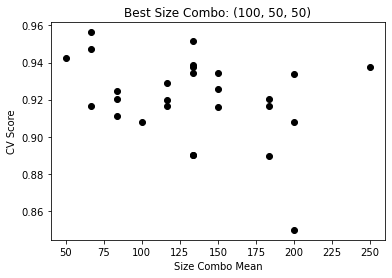

In [14]:
from statistics import mean

X_train = train[list(combos[0])]
X_test = test[list(combos[0])]


fig, ax = plt.subplots(1)

sizes = [50, 100, 250]
best_score = 0

for c1, c2, c3 in product(sizes, repeat =  3):
    
    clf = MLPClassifier(hidden_layer_sizes=(c1, c2, c3), max_iter=1000)
    cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    ax.scatter(mean([c1, c2, c3]), cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = (c1, c2, c3)
        best_score = cv_score
        
        
l = ax.set(title = "Best Size Combo: " + str(best_depth),
xlabel = "Size Combo Mean",
ylabel = "CV Score")
    

### The completed, trained model

In [26]:
# Train an MLPClassifier at best complexity, and evaluate the model on the test set

clf = MLPClassifier(hidden_layer_sizes=(50, 50, 100), max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

MLPClassifier(hidden_layer_sizes=(50, 50, 100), max_iter=1000)


0.9693877551020408

### Part 7 and 8

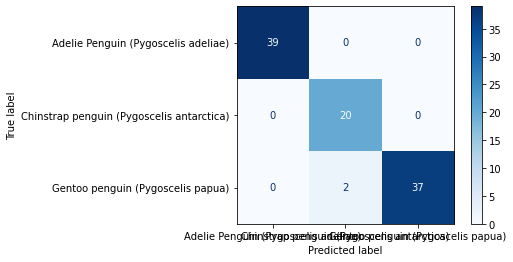

In [16]:
# Create and comment on a confusion matrix 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_train_pred = clf.predict(X_train)
c = confusion_matrix(y_train, y_train_pred)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues)

In [24]:
# Plot the decision regions
from sklearn import tree
def plot_regions(c, X, y):
        
    # for convenience, give names to the two 
    # columns of the data
    x0 = X['Flipper Length (mm)']
    x1 = X['Culmen Depth (mm)']
    
    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    XX = xx.ravel()
    YY = yy.ravel()
    XY = np.c_[XX, YY]
    
    p = c.predict(XY)
    p = p.reshape(xx.shape)
    
    # create the plot
    fig, ax = plt.subplots(1)
    
    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
    
    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
    ax.set(xlabel = "Flipper Length (mm)", 
           ylabel = "Culmen Depth (mm)")
    

print(X_train)

# Fit the model with dropped Sex column, so that it can have 2 columns for plot regions
clf.fit(X_train.drop(['Island'], axis=1), y_train)
'''
# Separate the males and females, drop the sex column, predict the y's and plot
X_male = X_train.loc[X_train['Island'] == 1]
X_male = X_male.drop(['Island'], axis=1)
y_male = clf.predict(X_male)

X_female = X_train.loc[X_train['Island'] == 2]
X_female = X_female.drop(['Island'], axis=1)
y_female = clf.predict(X_female)

plot_regions(clf, X_male, y_male)
plot_regions(clf, X_female, y_female)


# Fit the model with dropped Sex column, so that it can have 2 columns for plot regions
clf.fit(X_train.drop(['Sex'], axis=1), y_train)

# Separate the males and females, drop the sex column, predict the y's and plot
X_male = X_train.loc[X_train['Sex'] == 1]
X_male = X_male.drop(['Sex'], axis=1)
y_male = clf.predict(X_male)

X_female = X_train.loc[X_train['Sex'] == 2]
X_female = X_female.drop(['Sex'], axis=1)
y_female = clf.predict(X_female)

plot_regions(clf, X_male, y_male)
plot_regions(clf, X_female, y_female)
'''

     Island  Culmen Length (mm)  Culmen Depth (mm)
32        1                39.5               17.8
164       1                47.0               17.3
304       0                44.9               13.8
169       1                58.0               17.8
293       0                46.5               14.8
..      ...                 ...                ...
5         3                39.3               20.6
94        1                36.2               17.3
66        0                35.5               16.2
224       0                47.6               14.5
72        3                39.6               17.2

[226 rows x 3 columns]


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.